In [1]:
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop

Using TensorFlow backend.


In [2]:
d = {}
from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
# forms = pd.read_csv('../input/iam-handwriting-top50/forms_for_parsing.txt', header=None)
# print(forms.head)
with open("/Iamhandwriting/forms_for_parsing.txt") as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
        
print(len(d.keys()))
print(len(d))


1539
1539


In [3]:
tmp = []
target_list = []

path_to_files = os.path.join('C:/Iamhandwriting/data_subset/data_subset','*')
for filename in sorted(glob.glob(path_to_files)):
#     print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    form = form.split('set')[1][1:]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))
            

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)
print(image_name)


(4899,)
(4899,)
data_subset\r06-143-s04-01.png


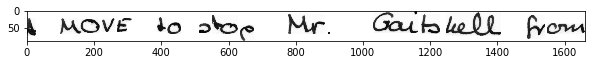

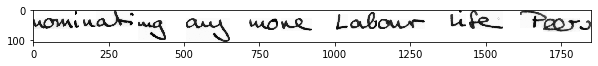

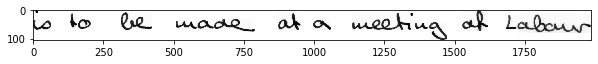

In [4]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')


In [5]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['C:/Iamhandwriting/data_subset/data_subset\\a01-000u-s00-00.png'
 'C:/Iamhandwriting/data_subset/data_subset\\a01-000u-s00-01.png'
 'C:/Iamhandwriting/data_subset/data_subset\\a01-000u-s00-02.png'
 'C:/Iamhandwriting/data_subset/data_subset\\a01-000u-s00-03.png'
 'C:/Iamhandwriting/data_subset/data_subset\\a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [6]:
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


In [7]:
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 8 #16
num_classes = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

In [8]:
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [9]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize_images(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)       

In [11]:
nb_epoch = 8

samples_per_epoch = 3268
nb_val_samples = 842

# #save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
#filepath="check-{epoch:02d}-{val_loss:.4f}.hdf5"
filepath="low_loss.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

# #Model fit generator
history_object = model.fit_generator(train_generator, steps_per_epoch = samples_per_epoch/batch_size,
                                      validation_data=validation_generator,
                                      validation_steps=nb_val_samples, epochs=nb_epoch, verbose=1, callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/8
409/408 [==============================] - 2198s 5s/step - loss: 3.5314 - acc: 0.1956 - val_loss: 2.9423 - val_acc: 0.2281

Epoch 00001: saving model to low_loss.hdf5
Epoch 2/8
409/408 [==============================] - 2128s 5s/step - loss: 2.7281 - acc: 0.2540 - val_loss: 2.3846 - val_acc: 0.3396

Epoch 00002: saving model to low_loss.hdf5
Epoch 3/8
409/408 [==============================] - 2066s 5s/step - loss: 2.3091 - acc: 0.3294 - val_loss: 1.9139 - val_acc: 0.4224

Epoch 00003: saving model to low_loss.hdf5
Epoch 4/8
409/408 [==============================] - 2105s 5s/step - loss: 2.0174 - acc: 0.4008 - val_loss: 1.5933 - val_acc: 0.5163

Epoch 00004: saving model to low_loss.hdf5
Epoch 5/8
409/408 [==============================] - 2119s 5s/step - loss: 1.7938 - acc: 0.4604 - val_loss: 1.4422 - val_acc: 0.5582

Epoch 00005: saving model to low_loss.hdf5
Epoch 6/8
409/408 [==

In [18]:
model.load_weights('low_loss.hdf5')
scores = model.evaluate_generator(test_generator,842) 
print("Accuracy = ", scores[1])

Accuracy =  0.6630860971218469


In [14]:
images = []
for filename in test_files[:50]:
     im = Image.open(filename)
     cur_width = im.size[0]
     cur_height = im.size[1]

     print(cur_width, cur_height)
     height_fac = 113 / cur_height

     new_width = int(cur_width * height_fac)
     size = new_width, 113

     imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
     now_width = imresize.size[0]
     now_height = imresize.size[1]
     # Generate crops of size 113x113 from this resized image and keep random 10% of crops

     avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

     # Pick random x%
     factor = 0.1
     pick_num = int(len(avail_x_points)*factor)
    
     random_startx = sample(avail_x_points,  pick_num)

     for start in random_startx:
         imcrop = imresize.crop((start, 0, start+113, 113))
         images.append(np.asarray(imcrop))
        
     X_test = np.array(images)
    
     X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
     #convert to float and normalize
     X_test = X_test.astype('float32')
     X_test /= 255
     shuffle(X_test)

     print(X_test.shape)

866 147
(55, 113, 113, 1)
1814 84
(287, 113, 113, 1)
813 105
(363, 113, 113, 1)
1871 160
(483, 113, 113, 1)
1037 83
(612, 113, 113, 1)
1228 66
(810, 113, 113, 1)
1702 101
(989, 113, 113, 1)
329 115
(1010, 113, 113, 1)
499 75
(1073, 113, 113, 1)
1683 93
(1266, 113, 113, 1)
717 76
(1361, 113, 113, 1)
149 88
(1368, 113, 113, 1)
1031 121
(1452, 113, 113, 1)
644 61
(1559, 113, 113, 1)
2029 81
(1830, 113, 113, 1)
870 77
(1946, 113, 113, 1)
1822 118
(2109, 113, 113, 1)
1837 137
(2249, 113, 113, 1)
1638 117
(2395, 113, 113, 1)
424 49
(2481, 113, 113, 1)
667 110
(2538, 113, 113, 1)
654 77
(2622, 113, 113, 1)
1217 74
(2796, 113, 113, 1)
441 111
(2829, 113, 113, 1)
386 66
(2883, 113, 113, 1)
1351 87
(3047, 113, 113, 1)
1928 145
(3185, 113, 113, 1)
1876 73
(3464, 113, 113, 1)
2025 117
(3648, 113, 113, 1)
826 85
(3746, 113, 113, 1)
1824 171
(3855, 113, 113, 1)
1843 143
(3989, 113, 113, 1)
1098 150
(4060, 113, 113, 1)
1721 113
(4220, 113, 113, 1)
1743 103
(4399, 113, 113, 1)
1730 167
(4504, 113, 113

In [15]:
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
    print(len(predicted_writer))

6351/6351 [==============================] - 3s 432us/step
(6351, 50)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
26